<div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);"> 🔥Natural Language Processing🔥 </div>




  <div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);"> 📂Importing Dependencies📂 </div>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.17.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


  <div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);"> 🛠Dataset Preprocessing🛠 </div>
  
  
In this notebook, I am using **Sentiment-140** from [Kaggle](https://www.kaggle.com/kazanova/sentiment140). It contains a labels data of 1.6 Million Tweets and we find it a good amount of data to train our model.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kazanova/sentiment140
!unzip sentiment140.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 72% 58.0M/80.9M [00:00<00:00, 216MB/s]
100% 80.9M/80.9M [00:00<00:00, 216MB/s]
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
df = pd.read_csv('./training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.sample(6).style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})

,0,1,2,3,4,5
1024718,4,1883326101,Fri May 22 08:22:22 PDT 2009,NO_QUERY,cycoivan,@DVDsnapshot You had me at naked
614710,0,2225997664,Thu Jun 18 11:24:23 PDT 2009,NO_QUERY,dynomitemon,@dianaescobedo that does suck who's getting married on the 4th of july?
441079,0,2066914009,Sun Jun 07 11:24:21 PDT 2009,NO_QUERY,oliverprivat,"Shit, plÃ¶tzlich sind 20 miener BlackBerry Messenger Kontakte weg. So`n mist"
655579,0,2240009330,Fri Jun 19 09:13:46 PDT 2009,NO_QUERY,cgoodwyn,Pixar flies employee and copy of UP for private viewing for 10 year old cancer patient. http://tr.im/p4r1 She died 7 hours after
1063238,4,1964397265,Fri May 29 14:10:17 PDT 2009,NO_QUERY,chicowoo,@daveingland I was wondering how u would do on your trip. U were doing good for a while but in last hour the tweet dam is bout to burst
759069,0,2296032110,Tue Jun 23 08:40:54 PDT 2009,NO_QUERY,the_sandman_,@ysi_ oh dear. R.I.P the 'brick'


We can see the columns are without any proper names. Lets rename them for our reference

In [ ]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head().style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


We are going to train only on text to classify its sentiment. So we can ditch the rest of the useless columns.

In [ ]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [ ]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head().style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})

Here are decoding the labels. We map **0 -> Negative and 4 -> Positive** as directed by the datset desciption. Now that we decoded we shall now analyse the dataset by its distribution. Because it's important that we have almost small amount of examples for given classes.

Text(0.5, 1.0, 'Sentiment Data Distribution')

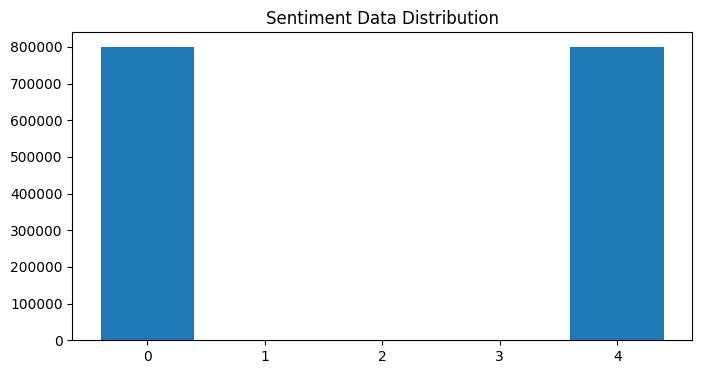

In [ ]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

It's a very good dataset without any skewness. Thank Goodness.

Now let us explore the data we having here...

In [ ]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10).style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'}) # Returns the rows with the index and display it

,sentiment,text
1598066,4,@Ruth_Z thanks for the retweet! have a great day
1482489,4,@brad_mcpherson We are for my moms birthday today! I've heard so much good stuff about it haha
818961,4,The best shift by far
867233,4,"@Madhobbit/Eerie,how olds tha building?Whats it used 4?Dyu mind me askn Qs or wud u prefer2 just post ur updates & get on with it? Suz"
1225031,4,gmorning hope you all had a great weekend!
1136527,4,@jordanknight is he alive? are you sure this time?
946533,4,@addamh I didn't! Which made it even funnier
428300,0,is revising
107295,0,i dont remember if i said this before but last weekend my highschool bac home in pa had their prom and sadly i want there 4 it
1178160,4,ok i need to write my babes letter so maybe i can send it out tomorrow..have a good sunday everybody!!


Looks like we have a nasty data in text. Because in general we use lot of punctuations and other words without any contextual meaning. It have no value as feature to the model we are training. So we need to get rid of them.

# Text Preprocessing
Tweet texts often consists of other user mentions, hyperlink texts, emoticons and punctuations. In order to use them for learning using a Language Model. We cannot permit those texts for training a model. So we have to clean the text data using various preprocessing and cleansing methods.


### Stemming/ Lematization
For grammatical reasons, documents are going to use different forms of a word, such as *write, writing and writes.* Additionally, there are families of derivationally related words with similar meanings. The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word
![Stemming and Lematization](https://qph.fs.quoracdn.net/main-qimg-cd7f4bafaa42639deb999b1580bea69f)

### Hyperlinks and Mentions
Twitter is a social media platform where people can tag and mentions other people's ID and share videos and blogs from internet. So the tweets often contain lots of Hyperlinks and twitter mentions.

- Twitter User Mentions - Eg. @arunrk7, @andrewng
- Hyperlinks - Eg. https://keras.io, https://tensorflow.org

### Stopwords
Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification. Some stopwords are...
![Stopwords English](https://4.bp.blogspot.com/-yiEr-jCVv38/Wmk10d84DYI/AAAAAAAAk0o/IfgjfjpgrxM5NosUQrGw7PtLvgr6DAG8ACLcBGAs/s1600/Screen%2BShot%2B2018-01-24%2Bat%2B5.41.21%2BPM.png)

**NLTK** is a python library which got functions to perform text processing task for NLP.



In [ ]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [ ]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [ ]:
df.text = df.text.apply(lambda x: preprocess(x))

Tensorflow Version 2.17.0
sentiment
0    800000
4    800000
Name: count, dtype: int64


Text(0.5, 1.0, 'Sentiment Data Distribution')

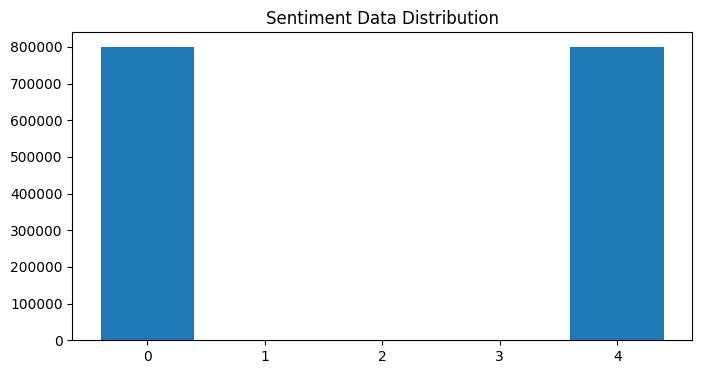

In [ ]:
# prompt: find out all the positive output

print("Tensorflow Version",tf.__version__)
#   <div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);"> 🛠Dataset Preprocessing🛠 </div>
#
#
# In this notebook, I am using **Sentiment-140** from [Kaggle](https://www.kaggle.com/kazanova/sentiment140). It contains a labels data of 1.6 Million Tweets and I find it a good amount of data to train our model.
# ... (rest of the code)

val_count = df.sentiment.value_counts()

print(val_count) #This will print the positive output.

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")
# ... (rest of the code)

**Aaww.. It is clean and tidy now. Now let's see some word cloud visualizations of it.**

### Positive Words

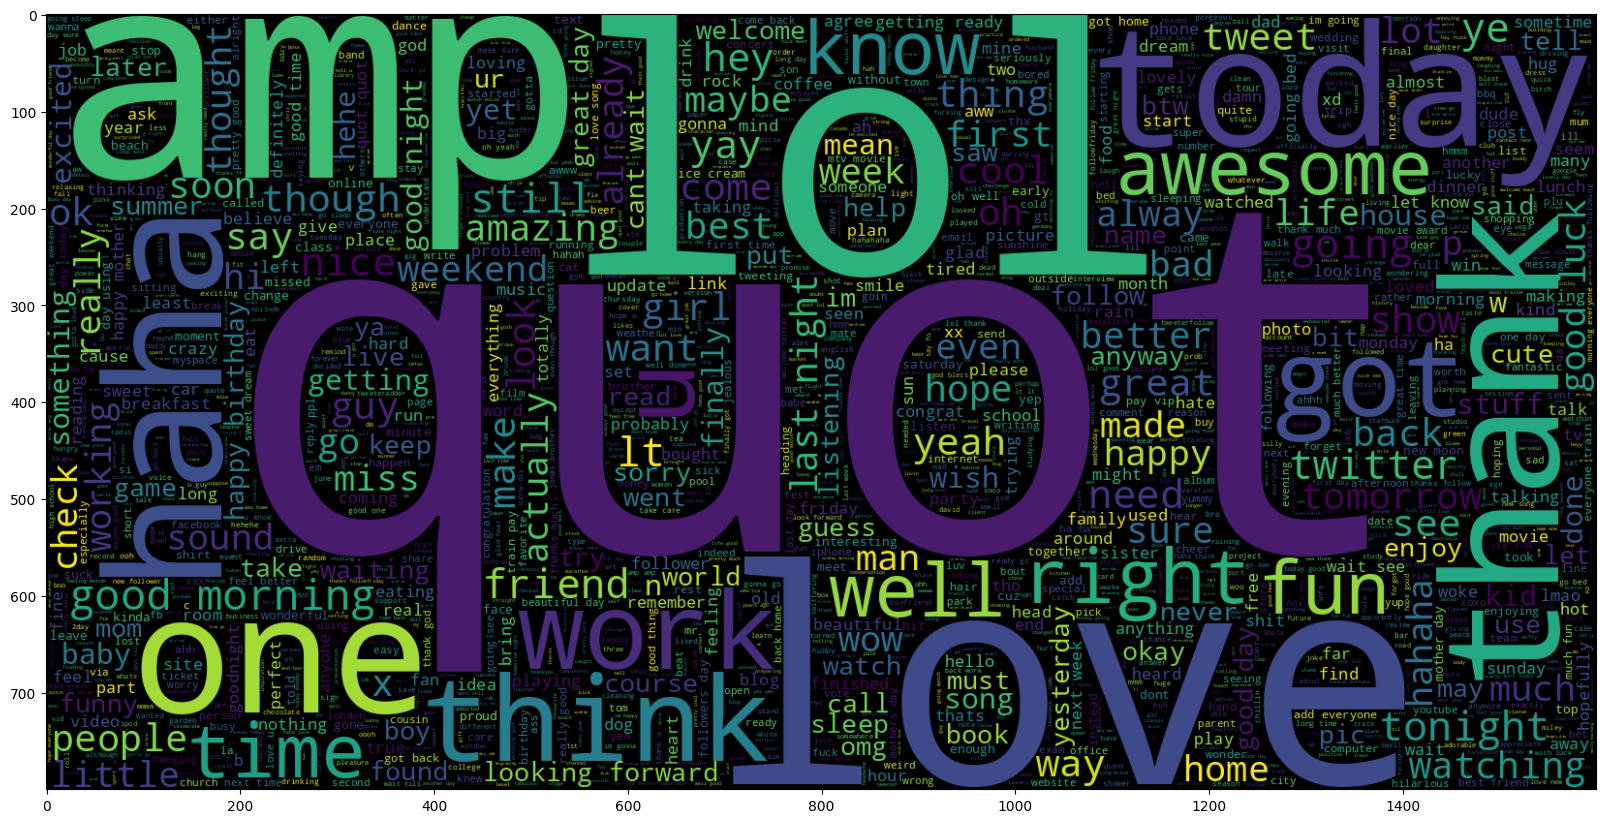

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 4].text))
plt.imshow(wc , interpolation = 'bilinear')

### Negative Words

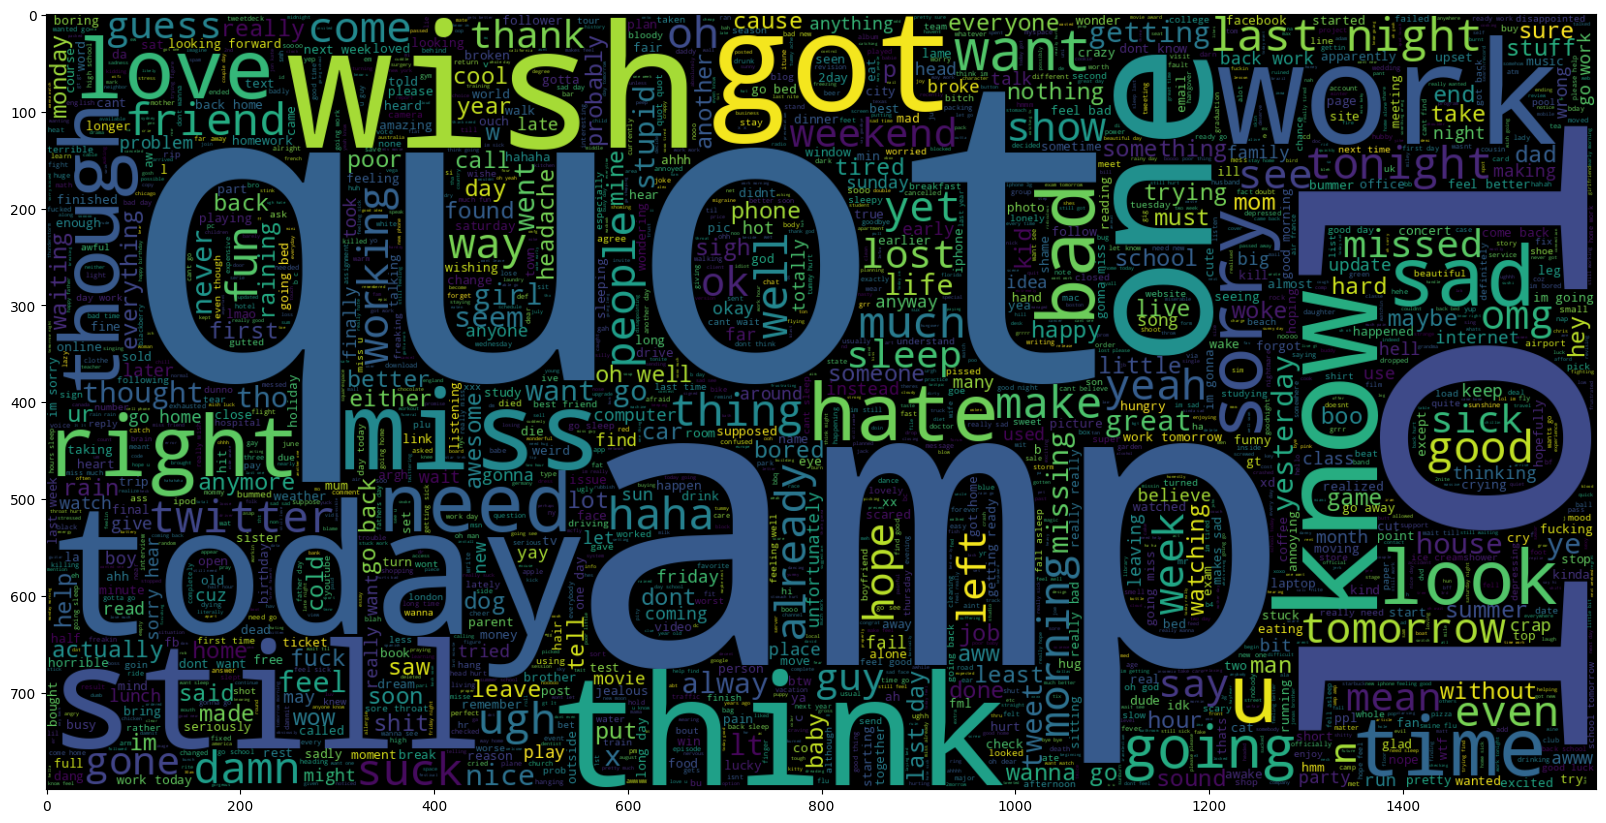

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

  <div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);"> 🛠Train and Test Split🛠 </div>

In [ ]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [ ]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


`train_test_split` will shuffle the dataset and split it to gives training and testing dataset. It's important to shuffle our dataset before training.

In [ ]:
train_data.sample(10).style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'}) # Returns the rows with the index and display it

,sentiment,text
940004,4,congrats making final two goodluck next week
1539429,4,way rephrased dtlr tweet makes seem like b coming dtlr raffle keeping u safe
1519388,4,big day tomorrow yay dont nervous fine wait hear
1128888,4,good
657697,0,tweettweeet missss kathryn lt 3
1538796,4,trying get ready work twitter distracting
632076,0,know finished really scared hahahahaah
1330096,4,someone already joined
1007160,4,sleep well tonight alton top yesterday ropes watch blog ropes session later
917058,4,good morning woke mother day


  <div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);"> 🛠Tokenization🛠 </div>

Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called *tokens* , perhaps at the same time throwing away certain characters, such as punctuation. The process is called **Tokenization.**
![Tokenization](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/11/tokenization.png)

`tokenizer` create tokens for every word in the data corpus and map them to a index using dictionary.

`word_index` contains the index for each word

`vocab_size` represents the total number of word in the data corpus

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


Now we got a `tokenizer` object, which can be used to covert any word into a Key in dictionary (number).

Since we are going to build a sequence model. We should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same lenght. But texts in tweets have different count of words in it. To avoid this, we seek a little help from `pad_sequence` to do our job. It will make all the sequence in one constant length `MAX_SEQUENCE_LENGTH`.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [ ]:
# prompt: what does it mean 30 col in xtrain

`MAX_SEQUENCE_LENGTH = 30` in the code sets the maximum length of the sequences (represented by the `x_train` and `x_test` variables) to 30.  This means that each tweet's text is converted into a sequence of numbers (tokens) and then padded or truncated to a fixed length of 30.

Here's a breakdown:

1. **Tokenization:** The text of each tweet is broken down into individual words (or sub-word units), and each unique word is assigned a numerical index (token).
2. **Sequencing:**  The tweet's text becomes a sequence of these numerical tokens, representing the order of the words in the original tweet.
3. **Padding/Truncation:** If a tweet's token sequence is shorter than 30, it's padded with zeros at the beginning to make it length 30. If a sequence is longer than 30, it's truncated (shortened) to the first 30 tokens.

So, `30` columns in `x_train` (and `x_test`) correspond to the 30 positions in this fixed-length sequence representation of each tweet's text. Each cell in a column represents a token (a number).  This uniform size is required for the input layer of neural networks, which expect consistent input dimensions.


array([[   0,    0,    0, ...,    0,   34,  110],
       [   0,    0,    0, ...,  133,  220, 2319],
       [   0,    0,    0, ..., 5649, 9960, 1060],
       ...,
       [   0,    0,    0, ...,  118, 1157,  687],
       [   0,    0,    0, ...,    1,  247,  107],
       [   0,    0,    0, ...,  665, 1308, 1868]], dtype=int32)

In [ ]:
labels = train_data.sentiment.unique().tolist()

  <div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);"> Label Encoding🛠 </div>

We are building the model to predict class in enocoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings.

In [ ]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


  <div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);"> 🛠Word Embedding🛠 </div>

# Word Emdedding
In Language Model, words are represented in a way to intend more meaning and for learning the patterns and contextual meaning behind it.

**Word Embedding** is one of the popular representation of document vocabulary.It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Basically, it's a feature vector representation of words which are used for other natural language processing applications.

We could train the embedding ourselves but that would take a while to train and it wouldn't be effective. So going in the path of Computer Vision, here we use **Transfer Learning**. We download the pre-trained embedding and use it in our model.

The pretrained Word Embedding like **GloVe & Word2Vec** gives more insights for a word which can be used for classification.


In this notebook, we use **GloVe Embedding from Stanford AI** which can be found [here](https://nlp.stanford.edu/projects/glove/)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-11-02 15:05:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-02 15:05:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-02 15:05:26--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
GLOVE_EMB = '/kaggle/working/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 50
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [ ]:
# prompt: update glove_emb and model_path to the right path

GLOVE_EMB = '/content/glove.6B.300d.txt'
MODEL_PATH = '/content/best_model.hdf5'

In [ ]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  <div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);"> 🔥Model Training - LSTM🔥 </div>

We are clear to build our Deep Learning model. While developing a DL model, we should keep in mind of key things like Model Architecture, Hyperparmeter Tuning and Performance of the model.

As you can see in the word cloud, the some words are predominantly feature in both Positive and Negative tweets. This could be a problem if we are using a Machine Learning model like Naive Bayes, SVD, etc.. That's why we use **Sequence Models**.

### Sequence Model
![Sequence Model](https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png)

Reccurent Neural Networks can handle a seqence of data and learn a pattern of input seqence to give either sequence or scalar value as output. In our case, the Neural Network outputs a scalar value prediction.

For model architecture, we use

1) **Embedding Layer** - Generates Embedding Vector for each input sequence.

2) **Conv1D Layer** - Its using to convolve data into smaller feature vectors.

3) **LSTM** - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4) **Dense** - Fully Connected Layers for classification


In [ ]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 30, 300)             │      87,172,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 30, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 26, 64)              │          96,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,663,829 (334.41 MB)

 Trainable params: 491,329 (1.87 MB)

 Non-trainable params: 87,172,500 (332.54 MB)

### Optimization Algorithm
This notebook uses Adam, optimization algorithm for Gradient Descent.

### Callbacks
Callbacks are special functions which are called at the end of an epoch. We can use any functions to perform specific operation after each epoch. I used two callbacks here,

- **LRScheduler** - It changes a Learning Rate at specfic epoch to achieve more improved result. In this notebook, the learning rate exponentionally decreases after remaining same for first 10 Epoch.

- **ModelCheckPoint** - It saves best model while training based on some metrics. Here, it saves the model with minimum Validity Loss.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

Let's start training... It takes a heck of a time if training in CPU.

In [ ]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Training on CPU...


In [ ]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=2,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/2
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1280s 1s/step - accuracy: 0.7600 - loss: 0.4923 - val_accuracy: 0.7729 - val_loss: 0.4717 - learning_rate: 0.0010
Epoch 2/2
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1307s 1s/step - accuracy: 0.7670 - loss: 0.4815 - val_accuracy: 0.7753 - val_loss: 0.4676 - learning_rate: 0.0010


  <div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);"> 📈Model Evaluation💹 </div>

Now that we have trained the model, we can evaluate its performance. We will some evaluation metrics and techniques to test the model.

Let's start with the Learning Curve of loss and accuracy of the model on each epoch.

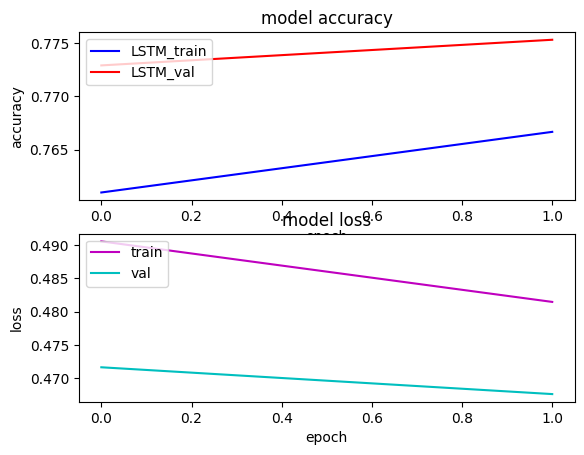

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

The model will output a prediction score between 0 and 1. We can classify two classes by defining a threshold value for it. In our case, I have set 0.5 as THRESHOLD value, if the score above it. Then it will be classified as **POSITIVE** sentiment.

In [ ]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step


  <div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);"> 🧾Confusion Matrix🧾 </div>

Confusion Matrix provide a nice overlook at the model's performance in classification task

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

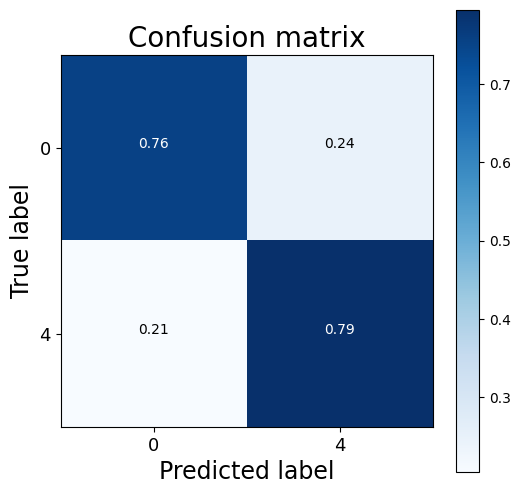

In [ ]:
# Convert test_data.sentiment to string labels before comparison.
# Assuming 0 corresponds to "Negative" and 1 to "Positive"
test_labels = ["Positive" if sentiment == 4 else "Negative" for sentiment in test_data.sentiment]

# Now calculate the confusion matrix:
cnf_matrix = confusion_matrix(test_labels, y_pred_1d)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

  <div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);"> 📜Classification Score📜 </div>

In [ ]:
print(classification_report(list(test_labels), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.79      0.76      0.77    160542
    Positive       0.76      0.79      0.78    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



It's a pretty good model we trained here in terms of NLP. Around 80% accuracy is good enough considering the baseline human accuracy also pretty low in these tasks. Also some tweets might have other languages than English. So our Embedding and Tokenizing wont have effect on them. But on practical scenario, this model is good for handling most tasks for Sentiment Analysis.